# Setup

## Import libraries

In [1]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv


from ipywidgets import interact, widgets, fixed
from plotly.express import imshow as imshow_interactive

In [2]:
from dotenv import load_dotenv

BASE_DIR = pathlib.Path(__name__).resolve().parent.parent.parent
load_dotenv(BASE_DIR / '.env')
DATA_PATH = pathlib.Path(os.getenv("DATA_PATH"))

## Import core modules

In [3]:
import sys
import pathlib
SRC_DIR = str(pathlib.Path(__name__).resolve().parent.parent)
sys.path.append(SRC_DIR)

In [4]:
from scanplot.setup_logger import logger

In [5]:
from scanplot.utils.read_image import read_image_rgb, read_image_gray
from scanplot.utils.drawing import draw_image, draw_points_on_canvas, draw_points_on_image, \
    draw_bbox
from scanplot.utils.widgets import init_points_num_slider, init_points_density_slider

In [6]:
from scanplot.core.template_match import template_match, detect_points, \
    find_tolerance_limit

from scanplot.core.clustering import simplify_points, agglomerative_clustering, meanshift_clustering

from scanplot.core.preprocess import replace_black_pixels

from scanplot.core.conv_map_operations import invert_convolution_map, normalize_map, \
    get_first_N_maximums, remove_nan_inf


from scanplot.core.process_template import template_tresholding, extract_largest_component, find_bbox, \
    crop_image, frame_image, is_grayscale, reconstruct_template_mask

from scanplot.core.hough_transform import generalized_hough_transform

from scanplot.core.parameters_search import linear_parameter_transform, get_corr_map_maximums

from scanplot.core.nms import apply_nms, point_to_bbox, get_bbox_from_point, get_bbox_center

In [7]:
# convolution implementation
from scanplot.core.convolution_from_stratch import get_image_part, sqdiff, \
    compute_mask_pixel_ratio, compute_mask_pixel_ratio_v2, sqdiff_normed_modification, \
    sqdiff_normed, cv_sqdiff_normed

# Pipeline

## Upload plot and template

In [8]:
PLOT_NUMBER = 59
MARKER_NUMBER = 2

PLOT_PATH = DATA_PATH / f"plot{PLOT_NUMBER}.png"
TEMPLATE_PATH = DATA_PATH / "markers_same_shape" / f"plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png"

In [9]:
source_image = read_image_rgb(PLOT_PATH)
source_template = read_image_rgb(TEMPLATE_PATH)

image = replace_black_pixels(source_image)
template = replace_black_pixels(source_template)

DEBUG - preprocess.py - replace_black_pixels: Number of black pixels on image: 3
DEBUG - preprocess.py - replace_black_pixels: Number of black pixels on image: 0


In [10]:
h_image, w_image = image.shape[0], image.shape[1]
h_template, w_template = template.shape[0], template.shape[1]

h_image, w_image

(243, 371)

([], [])

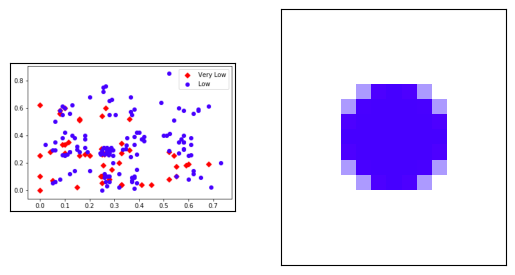

In [11]:
plt.subplot(1, 2, 1)
draw_image(image)
plt.xticks([]); plt.yticks([])

plt.subplot(1, 2, 2)
draw_image(template)
plt.xticks([]); plt.yticks([])

## Add ROI (optional)

In [12]:
# imshow_interactive(image)

In [13]:
# x_min, x_max, y_min, y_max = 221, 458, 47, 418
# roi_bbox = (x_min, x_max, y_min, y_max)

# image = crop_image(image, roi_bbox)

In [14]:
# imshow_interactive(image)

## Tresholding

([], [])

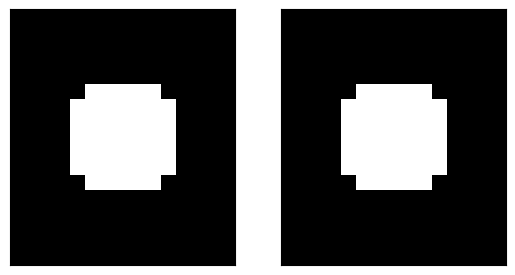

In [15]:
TRESHOLD_VALUE = 190
template_mask = template_tresholding(template, TRESHOLD_VALUE)
new_template_mask = reconstruct_template_mask(template_mask)

fig = plt.figure()
plt.subplot(1, 2, 1)
draw_image(template_mask)
plt.xticks([]); plt.yticks([])

plt.subplot(1, 2, 2)
draw_image(new_template_mask)
plt.xticks([]); plt.yticks([])

## Template matching

In [16]:
# method_name = 'SQDIFF_MODIFICATION_V3_WITH_HOUGH'
method_name = 'SQDIFF_MODIFICATION_V2'
method = "cv.TM_SQDIFF_NORMED"

convolution_map, _ = template_match(image, template, template_mask, method)
convolution_map2, _ = template_match(image, template, new_template_mask, method)

DEBUG - template_match.py - template_match: Convolution map bounds: (0.0, 1.370851)
DEBUG - template_match.py - template_match: Convolution map was inverted
DEBUG - template_match.py - template_match: Convolution map bounds: (0.0, 1.370851)
DEBUG - template_match.py - template_match: Convolution map was inverted


## Hough transform

In [17]:
accumulator = generalized_hough_transform(image, template, norm_result=True, crop_result=True)

assert convolution_map.shape == accumulator.shape

## Combine convolution maps

In [18]:
convolution_map = normalize_map(convolution_map)
convolution_map2 = normalize_map(convolution_map2)

convolution_map3 = convolution_map + 0.7 * convolution_map2
convolution_map3 = normalize_map(convolution_map3)

convolution_map4 = convolution_map + 0.6 * accumulator
convolution_map4 = normalize_map(convolution_map4)

In [19]:
# imshow_interactive(convolution_map)

## Interactive parameters search

1) `points_num` - отвечает за количество точек (чем больше, тем больше точек детектируется)

`points_num` = 0 => 1 точка

`points_num` = 100 => бесконечно много точек 


2) `points_density` - отвечает за плотность точек (чем больше, тем **разреженнее** результат)

`points_density` = 0 => не применяем NMS

`points_density` = 100 => убираем очень много соседей

In [20]:
# TODO: move to separate module

def detect_points_on_map(
        points_num: float,
        points_density: float,
        correlation_map: np.ndarray,
        draw_detections: bool = True,
        return_result: bool = False,
        figure_size: int = 10,
        marker_size: int = 60,
        marker_color: str = "yellow"
) -> np.ndarray | None:
    
    ## transform parameters
    corr_map_treshold = linear_parameter_transform(points_num, a=-0.01, b=1)
    iou_treshold = linear_parameter_transform(points_density, a=-0.01, b=1)

    ## get max points
    max_points, _ = get_corr_map_maximums(
        correlation_map=correlation_map,
        treshold=corr_map_treshold
    )
    
    ## NMS
    actual_points = apply_nms(
        points=max_points,
        correlation_map=correlation_map,
        iou_treshold=iou_treshold,
        bbox_width=w_template,   # TODO: this is global variable, fix it (!)
        bbox_height=h_template   # TODO: this is global variable, fix it (!)
    )
    x_nms = actual_points[:, 0]
    y_nms = actual_points[:, 1]
    number_of_points = len(actual_points)


    ## draw founded points on original image
    if draw_detections:
        plt.figure(figsize=(figure_size, figure_size))
        draw_image(source_image)
        plt.scatter(x_nms, y_nms, 
                    s=marker_size, c=marker_color, marker="*", 
                    edgecolors='black', linewidths=0.2)
        plt.xticks([]); plt.yticks([])
        plt.title(f"{corr_map_treshold=:.3f}, {iou_treshold=:.2f}, {number_of_points=}")
        plt.show()

    if return_result:
        return actual_points

In [21]:
# parameters for drawing detections (may be customized)
figure_size = 12
marker_size = 200
marker_color = "yellow"


interact(
    detect_points_on_map,
    points_num=init_points_num_slider(),  # variable
    points_density=init_points_density_slider(),  # variable
    correlation_map=fixed(convolution_map4),  # constants
    draw_detections=fixed(True),
    return_result=fixed(False),
    figure_size=fixed(figure_size),
    marker_size=fixed(marker_size),
    marker_color=fixed(marker_color),
    continuous_update=True
);

interactive(children=(FloatSlider(value=20.0, description='Points Number:', layout=Layout(width='500px'), read…

In [22]:
points = detect_points_on_map(points_num=49,
    points_density=20,
    correlation_map=convolution_map4,
    draw_detections=False,
    return_result=True)

points = points.astype(np.int64)

In [ ]:
# @interact(points_num=widgets.FloatSlider(value=20, min=0, max=100, step=1),
#           points_density=widgets.FloatSlider(value=20, min=0, max=100, step=1))
# def visualize(points_num, points_density):
    

#     CORR_MAP = convolution_map3
    
#     ## transform parameters
#     corr_map_treshold = linear_parameter_transform(points_num, a=-0.01, b=1)
#     iou_treshold = linear_parameter_transform(points_density, a=-0.01, b=1)

#     ## get max points
#     max_points, number_of_maximums = get_corr_map_maximums(
#         correlation_map=CORR_MAP,
#         treshold=corr_map_treshold
#     )
    
#     ## NMS
#     actual_points = apply_nms(
#         points=max_points,
#         correlation_map=CORR_MAP,
#         iou_treshold=iou_treshold,
#         bbox_width=w_template,
#         bbox_height=h_template
#     )
#     x_nms = actual_points[:, 0]
#     y_nms = actual_points[:, 1]

#     ## draw founded points on original image
#     plt.figure(figsize=(9, 9))
#     draw_image(source_image)
#     plt.scatter(x_nms, y_nms, s=60, c="yellow", marker="*",  edgecolors='black', linewidths=0.2)
#     # plt.xticks([]); plt.yticks([]);
#     plt.title(f"{corr_map_treshold=}, {iou_treshold=}, {number_of_maximums=}")
#     plt.show()

#     # ## draw founded points on clear canvas
#     # plt.figure(figsize=(10, 6))
#     # draw_points_on_canvas(actual_points, source_image)

## Experiments

In [23]:
from scanplot.core.reconstruction import get_bbox_by_center_point, insert_template_into_image

In [27]:
reconsctuction = image.copy()
reconsctuction[:, :] = 255

history = []

template_non_mask_indexes = np.where(template_mask != 0)

for point in points:
    bbox = get_bbox_by_center_point(center_point=point, width=w_template, height=h_template)
    reconsctuction = insert_template_into_image(
        reconsctuction,
        template,
        bbox,
        template_mask
    )

    diff = cv.matchTemplate(image, reconsctuction, cv.TM_CCOEFF_NORMED)[0][0]
    history.append(diff)

    # plt.imshow(reconsctuction)
    # plt.title(f"{diff=}")
    # plt.show()

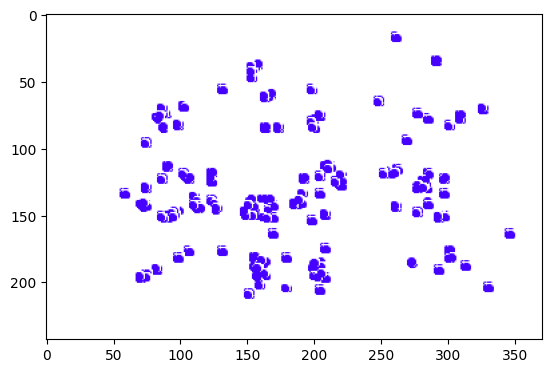

In [28]:
draw_image(reconsctuction)

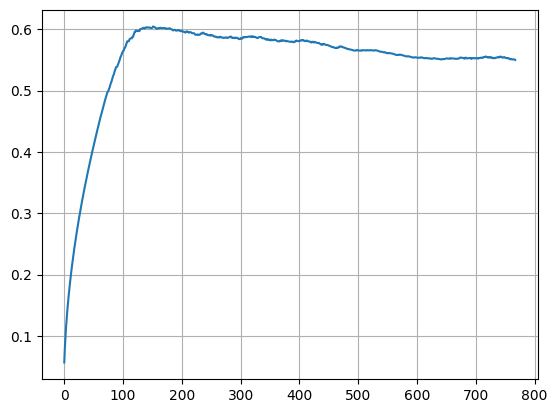

In [29]:
plt.plot(history)
plt.grid()